In [1]:
%matplotlib inline

import os
from glob import glob

import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

from ipywidgets import interact

from IPython.core.pylabtools import figsize

In [2]:
figsize(15, 9)
figsize(15, 9)

sns.set()

pd.set_option('display.max_columns', 50)

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data_dir = 'data'

In [60]:
country_map = {
    'US': 'United_States',
    'United States of America': 'United_States',
    'Czechia': 'Czech_Republic',
    'UK': 'United_Kingdom',
    'United Kingdom of Great Britain and Northern Ireland': 'United_Kingdom',
    'Hong Kong SAR': 'Hong_Kong',
    'Russian Federation': 'Russia',
    'Mainland China': 'China',
    'Korea, South': 'South_Korea',
    'Republic of Korea': 'South_Korea',
    'Korea, Republic of': 'South_Korea',
    "Iran, Islamic Republic of": "Iran",
    'Taiwan, Province of China': 'Taiwan',
    'Viet Nam': 'Vietnam',
    'Palestine, State of': 'Palestine',
    'Faroe Islands': 'Faeroe_Islands',
    'Australia[g]': 'Australia',
    'Finland[l]': 'Finland',
    'France[b]': 'France',
    'Malaysia[f]': 'Malaysia',
    'Netherlands[i]': 'Netherlands',
    'Norway[m]': 'Norway',
    'Spain[d]': 'Spain',
    'Ukraine[e]': 'Ukraine',
}

## Population By Country

https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)

In [61]:
pop_df = pd.read_csv(os.path.join(data_dir, 'population.csv'))
pop_df['Country'] = pop_df['Country or area'].map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))
pop_df['population'] = pop_df['Population(1 July 2019)'].map(lambda x: x.replace(',', '')).astype('float64')
pop_df = pop_df[['Country', 'population']].copy()
pop_df.head()

,Country,population
0,China,1.433784e+09
1,India,1.366418e+09
2,United_States,3.290649e+08
3,Indonesia,2.706256e+08
4,Pakistan,2.165653e+08


## COVID-19 Data

https://github.com/CSSEGISandData/COVID-19

In [62]:
covid_time_series_confirmed_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

covid_time_series_recovered_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

covid_time_series_death_path = \
    './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'


confirmed_df = pd.read_csv(covid_time_series_confirmed_path).drop(['Lat', 'Long'], axis=1)
confirmed_df = \
    confirmed_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Confirmed')\
        .copy()

recovered_df = pd.read_csv(covid_time_series_recovered_path).drop(['Lat', 'Long'], axis=1)
recovered_df = \
    recovered_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Recovered')\
        .copy()

deaths_df = pd.read_csv(covid_time_series_death_path).drop(['Lat', 'Long'], axis=1)
deaths_df = \
    deaths_df\
        .rename(columns={'Province/State': 'State', 'Country/Region': 'Country'})\
        .melt(['State', 'Country'], var_name='Date', value_name='Deaths')\
        .copy()

MERGE_COLS = ['State', 'Country', 'Date']
covid_df = \
    confirmed_df\
        .merge(recovered_df, on=MERGE_COLS)\
        .merge(deaths_df, on=MERGE_COLS)

covid_df = covid_df[covid_df[['Confirmed', 'Recovered', 'Deaths']].notnull().values.all(axis=1)]

covid_df['Active'] = covid_df['Confirmed'] - covid_df['Deaths'] - covid_df['Recovered']

covid_df['Country'] = \
    covid_df['Country'].map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))

covid_df['Date'] = pd.to_datetime(covid_df['Date']).dt.date

covid_df = covid_df.groupby(['Country', 'Date']).sum().reset_index().copy()
covid_df['Date'] = pd.to_datetime(covid_df['Date'])

covid_df[covid_df['Country'] == 'Indonesia'].tail()

,Country,Date,Confirmed,Recovered,Deaths,Active
4692,Indonesia,2020-03-18,227,11,19,197
4693,Indonesia,2020-03-19,311,11,25,275
4694,Indonesia,2020-03-20,369,15,32,322
4695,Indonesia,2020-03-21,450,15,38,397
4696,Indonesia,2020-03-22,514,29,48,437


## Country Codes

https://datahub.io/core/country-list

In [63]:
code_df = pd.read_csv(os.path.join(data_dir, 'country_codes.csv'))
code_df['Country'] = code_df['Name'].map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))
code_df.head()

,Name,Code,Country
0,Afghanistan,AF,Afghanistan
1,Åland Islands,AX,Åland_Islands
2,Albania,AL,Albania
3,Algeria,DZ,Algeria
4,American Samoa,AS,American_Samoa


## Testing Data

https://ourworldindata.org/covid-testing

https://ourworldindata.org/coronavirus-testing-source-data#country-by-country-statistics-and-sources

In [64]:
country_test_df = pd.read_csv(os.path.join(data_dir, 'covid-19-tests-country.csv'))
country_test_df = country_test_df[country_test_df['Code'].notnull()].copy()
country_test_df['Country'] = \
    country_test_df['Entity'].map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))
country_test_df['Tests_export'] = country_test_df['Total COVID-19 tests']

per_million_test_df = pd.read_csv(os.path.join(data_dir, 'covid19-tests-per-million-people.csv'))
per_million_test_df = per_million_test_df[per_million_test_df['Code'].notnull()].copy()

table_test_df = pd.read_csv(os.path.join(data_dir, 'covid_test_data.csv'))
table_test_df['Country'] = \
    table_test_df['Country or territory'].str.split(' – ').str[0]\
        .map(lambda x: country_map.get(x, x.strip().replace(' ', '_')))
table_test_df['Date'] = pd.to_datetime(table_test_df['Date'])
table_test_df = \
    table_test_df\
        .groupby('Country')\
        .agg({'Total tests': 'sum', 'Date': 'max'})\
        .reset_index()\
        .merge(code_df, on='Country', how='inner')
table_test_df['Tests_table'] = table_test_df['Total tests']

In [65]:
print(len(country_test_df))
print(country_test_df['Entity'].unique())
country_test_df.head()

59
['Armenia' 'Australia' 'Austria' 'Bahrain' 'Belarus' 'Belgium' 'Brazil'
 'Colombia' 'Costa Rica' 'Croatia' 'Czech Republic' 'Denmark' 'Estonia'
 'Faeroe Islands' 'Finland' 'France' 'Germany' 'Hong Kong' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kyrgyzstan' 'Latvia' 'Lithuania' 'Malaysia' 'Malta' 'Mexico'
 'Netherlands' 'New Zealand' 'Norway' 'Pakistan' 'Palestine' 'Panama'
 'Philippines' 'Poland' 'Qatar' 'Romania' 'Russia' 'Slovakia' 'Slovenia'
 'South Africa' 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Taiwan'
 'Thailand' 'Turkey' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States' 'Vietnam']


,Entity,Code,Year,Total COVID-19 tests,Country,Tests_export
0,Armenia,ARM,57,813,Armenia,813
1,Australia,AUS,59,113615,Australia,113615
9,Austria,AUT,59,15613,Austria,15613
10,Bahrain,BHR,59,18645,Bahrain,18645
11,Belarus,BLR,55,16000,Belarus,16000


In [66]:
print(len(per_million_test_df))
print(per_million_test_df['Entity'].unique())
per_million_test_df.head()

60
['Armenia' 'Australia' 'Austria' 'Bahrain' 'Belarus' 'Belgium' 'Brazil'
 'Colombia' 'Costa Rica' 'Croatia' 'Czech Republic' 'Denmark' 'Estonia'
 'Faeroe Islands' 'Finland' 'France' 'Germany' 'Hong Kong' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kuwait' 'Kyrgyzstan' 'Latvia' 'Lithuania' 'Malaysia' 'Malta' 'Mexico'
 'Netherlands' 'New Zealand' 'Norway' 'Pakistan' 'Palestine' 'Panama'
 'Philippines' 'Poland' 'Qatar' 'Romania' 'Russia' 'Slovakia' 'Slovenia'
 'South Africa' 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Taiwan'
 'Thailand' 'Turkey' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States' 'Vietnam']


,Entity,Code,Year,Total COVID-19 tests per million people
0,Armenia,ARM,57,276.7
1,Australia,AUS,59,4473.4
9,Austria,AUT,59,1777.8
10,Bahrain,BHR,59,10982.1
11,Belarus,BLR,55,1699.3


In [67]:
merged_comparison = \
    country_test_df[['Country', 'Tests_export']]\
        .merge(table_test_df[['Country', 'Tests_table']], on='Country', how='outer')

merged_comparison[merged_comparison['Tests_table'] != merged_comparison['Tests_export']]

,Country,Tests_export,Tests_table
1,Australia,113615.0,227230.0
57,United_States,103945.0,141591.0
59,Canada,NaN,113121.0
60,China,NaN,320000.0
61,Kuwait,NaN,0.0


In [68]:
pop_df[pop_df['Country'].map(lambda x: 'Ukraine' in x)]

,Country,population
32,Ukraine,43993638.0


In [69]:
set(merged_test_data['Country']) - set(pop_df['Country'])

set()

In [73]:
merged_test_data = \
    table_test_df[['Country', 'Code', 'Date', 'Tests_table']].rename({'Tests_table': 'Tests'}, axis=1)\
        .merge(
            covid_df[['Country', 'Date', 'Confirmed', 'Active', 'Deaths', 'Recovered']],
            on=['Country', 'Date'],
            how='inner'
        ).merge(pop_df, on='Country', how='inner')
print(len(merged_test_data))
merged_test_data['Death_Rate'] = merged_test_data['Deaths'] / merged_test_data['Confirmed']
merged_test_data['Log_Deaths'] = np.log(merged_test_data['Deaths'])
merged_test_data['Log_Confirmed'] = np.log(merged_test_data['Confirmed'])
merged_test_data['Log_Tests'] = np.log(merged_test_data['Tests'])
merged_test_data['Tests_Per_Capita'] = 100000 * merged_test_data['Tests'] / merged_test_data['population']
merged_test_data[merged_test_data['Country'] == 'United_States']

58


/home/dan/dev/src/covid_analysis/v/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/dan/dev/src/covid_analysis/v/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/dan/dev/src/covid_analysis/v/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


,Country,Code,Date,Tests,Confirmed,Active,Deaths,Recovered,population,Death_Rate,Log_Deaths,Log_Confirmed,Log_Tests,Tests_Per_Capita
56,United_States,US,2020-03-19,141591.0,13677,13477,200,0,329064917.0,0.014623,5.298317,9.523471,11.860698,43.028288


In [72]:
merged_test_data

,Country,Code,Date,Tests,Confirmed,Active,Deaths,Recovered,population,Death_Rate,Log_Deaths,Log_Confirmed,Log_Tests
0,Armenia,AM,2020-03-18,813.0,84,83,0,1,2.957731e+06,0.000000,-inf,4.430817,6.700731
1,Australia,AU,2020-03-20,227230.0,791,758,7,26,2.520320e+07,0.008850,1.945910,6.673298,12.333718
2,Austria,AT,2020-03-20,15613.0,2388,2373,6,9,8.955102e+06,0.002513,1.791759,7.778211,9.655859
3,Bahrain,BH,2020-03-20,18645.0,285,184,1,100,1.641172e+06,0.003509,0.000000,5.652489,9.833333
4,Belarus,BY,2020-03-16,16000.0,36,33,0,3,9.452411e+06,0.000000,-inf,3.583519,9.680344
5,Belgium,BE,2020-03-18,18360.0,1486,1441,14,31,1.153933e+07,0.009421,2.639057,7.303843,9.817930
6,Brazil,BR,2020-03-13,2927.0,151,151,0,0,2.110495e+08,0.000000,-inf,5.017280,7.981733
7,Canada,CA,2020-03-20,113121.0,943,922,12,9,3.741105e+07,0.012725,2.484907,6.849066,11.636213
8,China,CN,2020-02-24,320000.0,77241,49631,2595,25015,1.433784e+09,0.033596,7.861342,11.254686,12.676076
9,Colombia,CO,2020-03-20,4103.0,128,127,0,1,5.033944e+07,0.000000,-inf,4.852030,8.319474


In [13]:
def annotate_with_index(ax, plot_df, x_col, y_col):
    for k, row in plot_df.iterrows():
        x = row[x_col]
        y = row[y_col]
        ax.annotate(
            k,
            (x, y),
            xytext=(-5, 10), textcoords='offset points',
            family='sans-serif', fontsize=12, color='darkslategrey'
        )
    
def plot_this(df, x_col, y_col, logx=True, logy=True):
    plot_df = df[
        (df[x_col] > 0.0) & 
        (df[y_col] > 0.0)
    ].set_index('Code').copy()

    ax = plt.subplot(1,1,1)
    
    if logx and logy:
        plt.loglog(plot_df[x_col], plot_df[y_col], 'o') 
    elif logy:
        plt.semilogy(plot_df[x_col], plot_df[y_col], 'o')
    elif logx:
        plt.semilogx(plot_df[x_col], plot_df[y_col], 'o')
    else:
        plt.plot(plot_df[x_col], plot_df[y_col], 'o')
        
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    annotate_with_index(ax, plot_df, x_col, y_col)

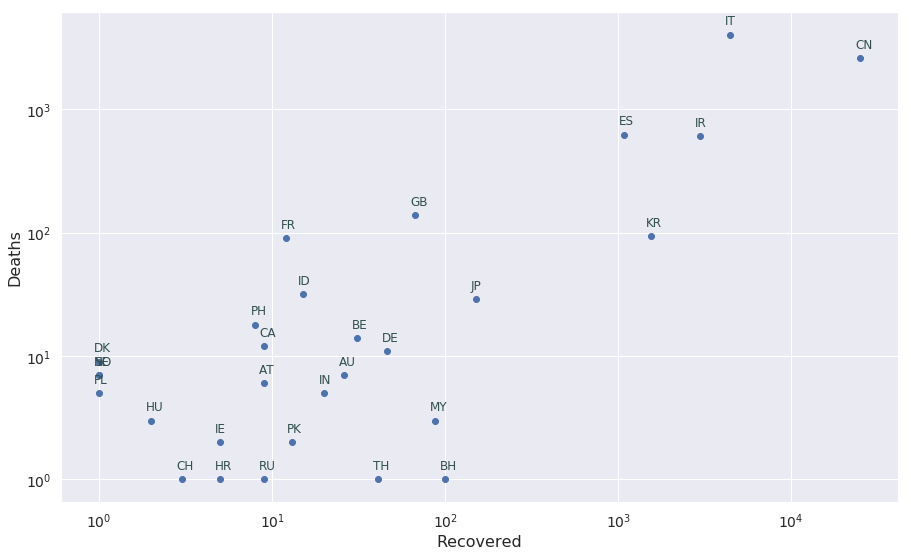

In [14]:
plot_this(merged_test_data, 'Recovered', 'Deaths')
plt.show()

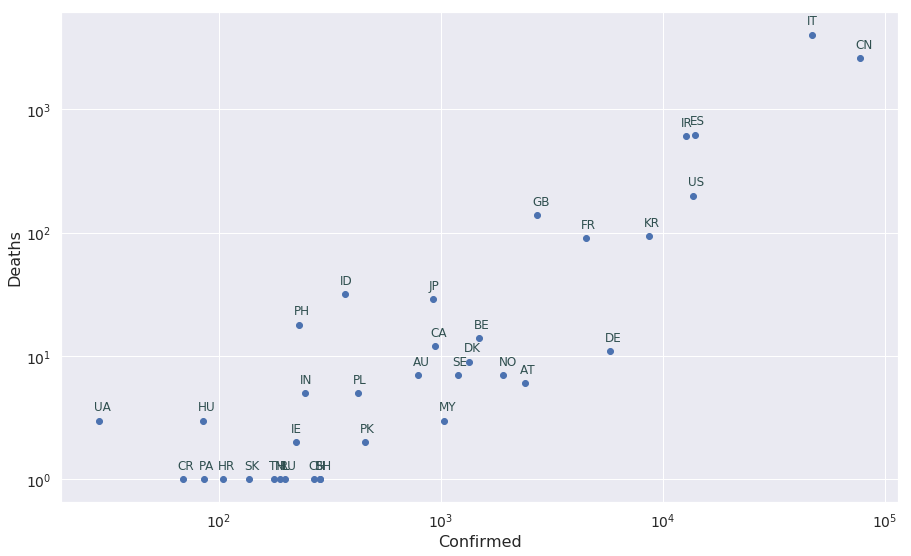

In [15]:
plot_this(merged_test_data, 'Confirmed', 'Deaths')
plt.show()

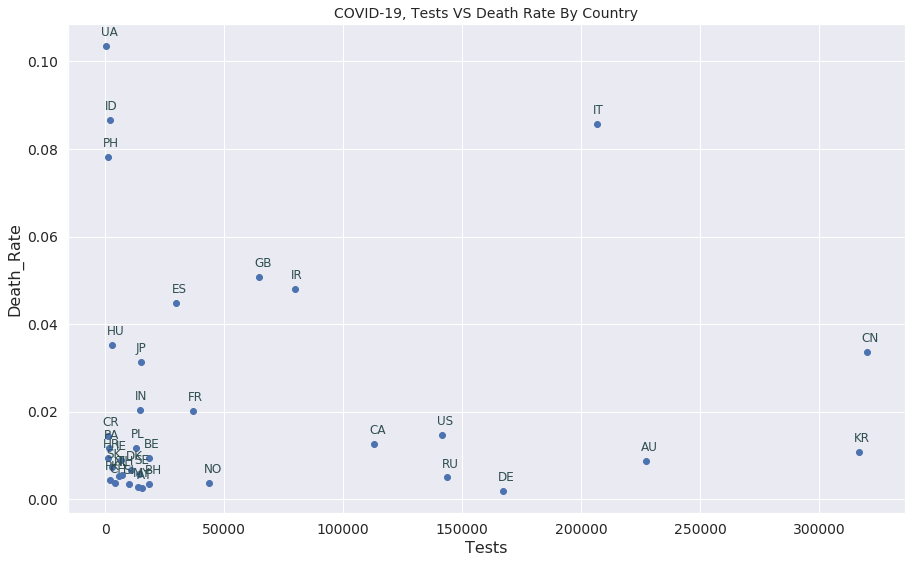

In [16]:
plot_this(merged_test_data, 'Tests', 'Death_Rate', logy=False, logx=False)
plt.title('COVID-19, Tests VS Death Rate By Country')
plt.show()

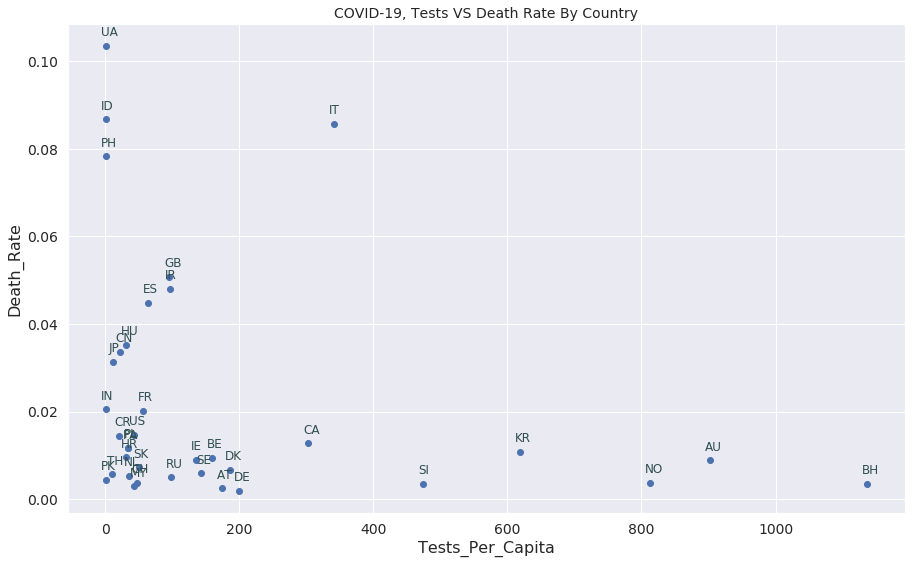

In [74]:
plot_this(merged_test_data, 'Tests_Per_Capita', 'Death_Rate', logy=False, logx=False)
plt.title('COVID-19, Tests VS Death Rate By Country')
plt.show()

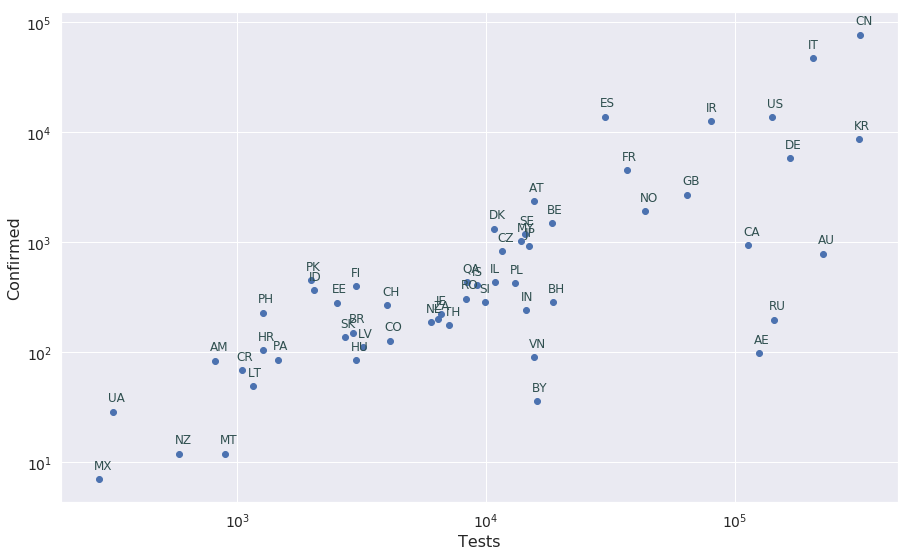

In [17]:
plot_this(merged_test_data, 'Tests', 'Confirmed')
plt.show()

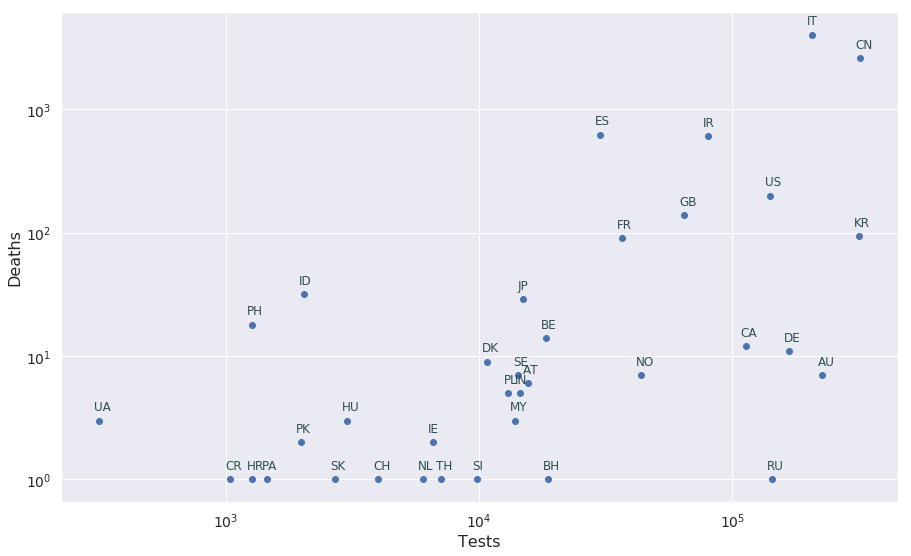

In [18]:
plot_this(merged_test_data, 'Tests', 'Deaths')
plt.show()